## 1. Visualizing Intermediate Activations:

### 1.1. Loading the Model:

In [2]:

from keras.models import load_model
model = load_model('cats_n_dogs_small_1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### 1.2. Pre-Processing a Single Image:

Image Tensor Shape:  (1, 150, 150, 3)


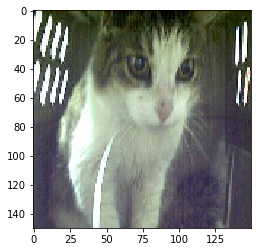

In [18]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

img_path = 'E:\\Anirban_Research\\Experimentation_beg\\sample_cats_n_dogs\\sample\\train\\cats\\cat.2921.jpg'
img = image.load_img(img_path,target_size = (150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis = 0)
img_tensor /= 255.
print('Image Tensor Shape: ',img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

### 1.3. Instantiating a Model from an input tensor and a list of output tensors:

In [9]:
from keras import models

layers_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input,outputs=layers_outputs)
activations = activation_model.predict(img_tensor)   #Running the model in predict mode.


#print(len(model.layers))

### 1.4. Visualizing the first layer activation for two channels for example case:

First Layer Activation Shape:  (1, 148, 148, 32)



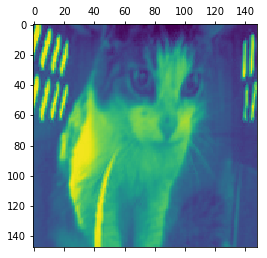

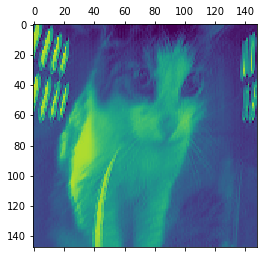

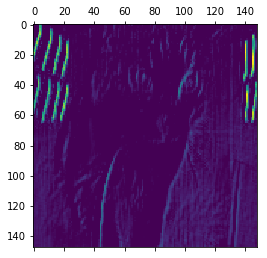

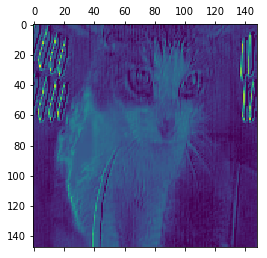

In [23]:
first_layer_activation = activations[0]
print('First Layer Activation Shape: ',first_layer_activation.shape)
print()

plt.matshow(first_layer_activation[0,:,:,4],cmap='viridis')
plt.matshow(first_layer_activation[0,:,:,8],cmap='viridis')
plt.matshow(first_layer_activation[0,:,:,20],cmap='viridis')
plt.matshow(first_layer_activation[0,:,:,30],cmap='viridis')
#plt.show()



### 1.5. Visualizing every-channel in every intermediate activations:

C:\Users\home\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


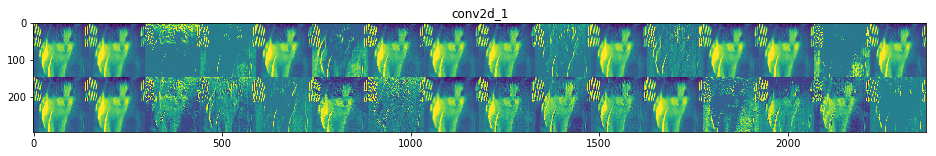

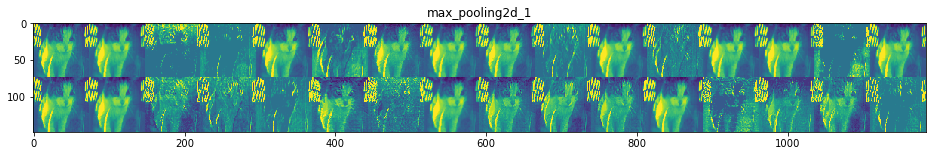

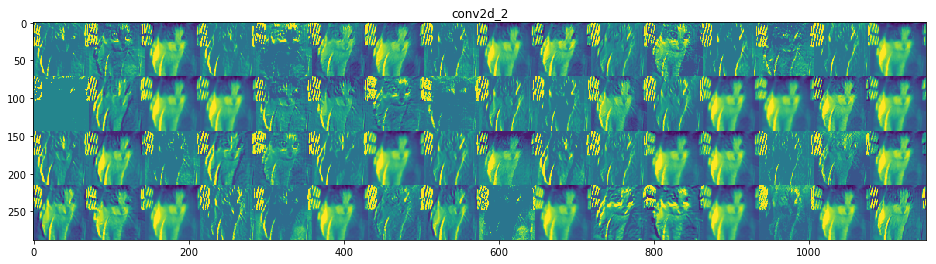

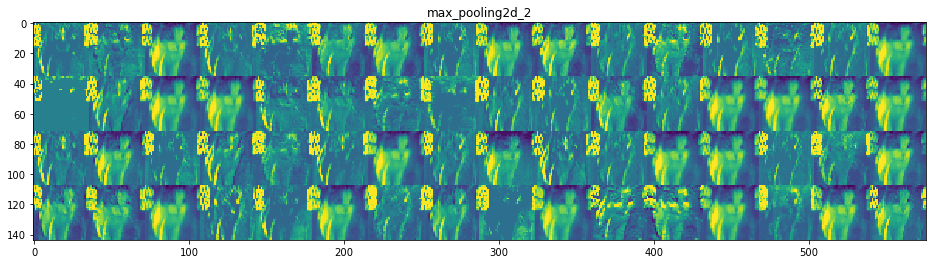

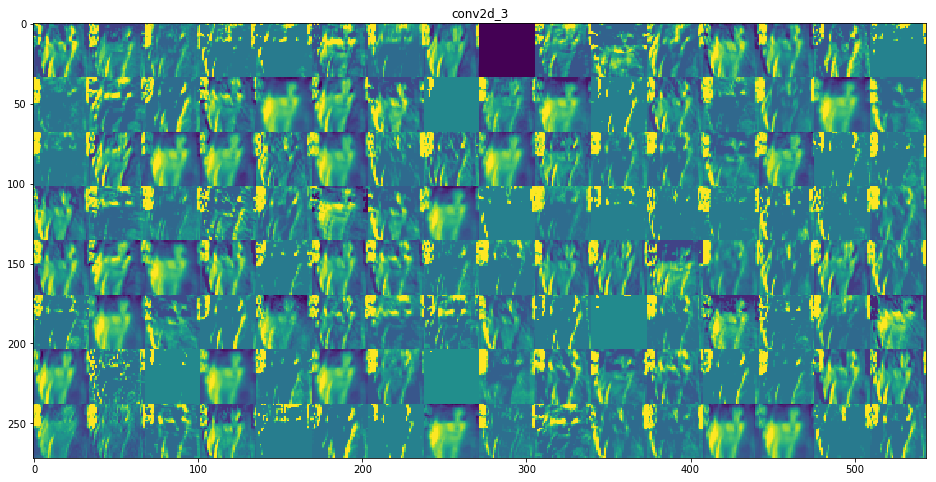

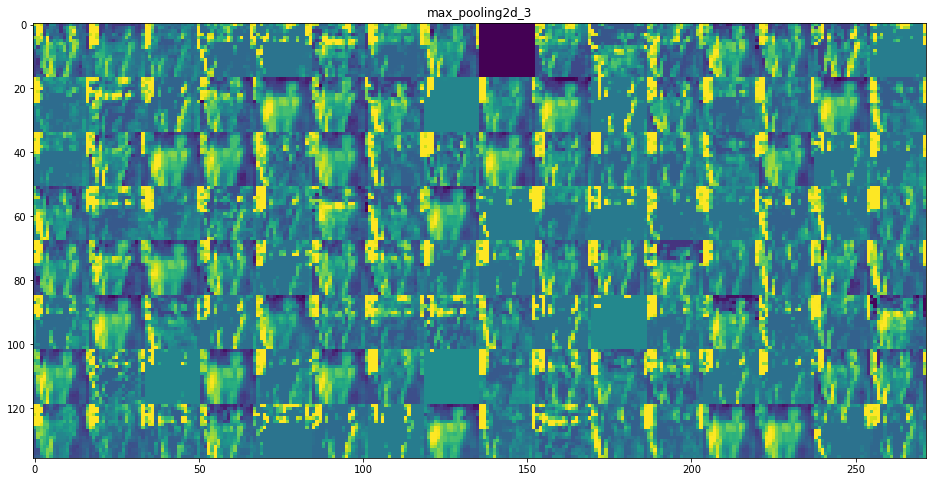

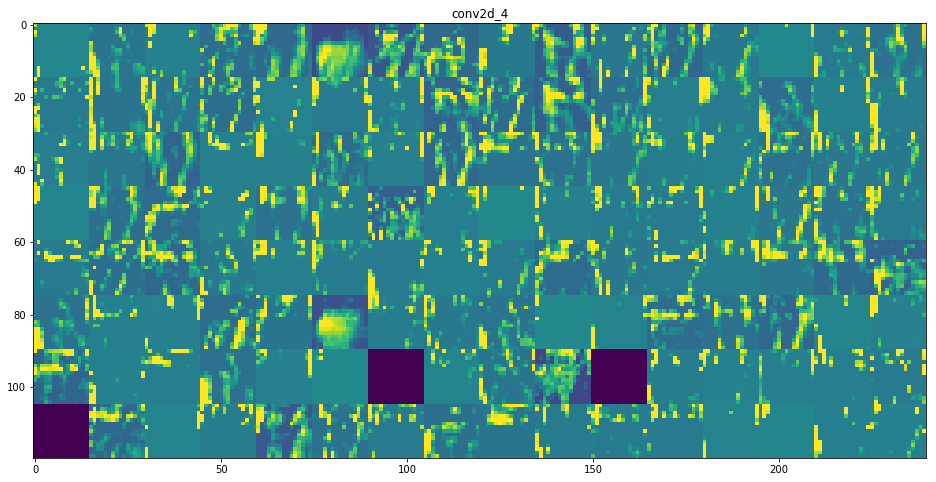

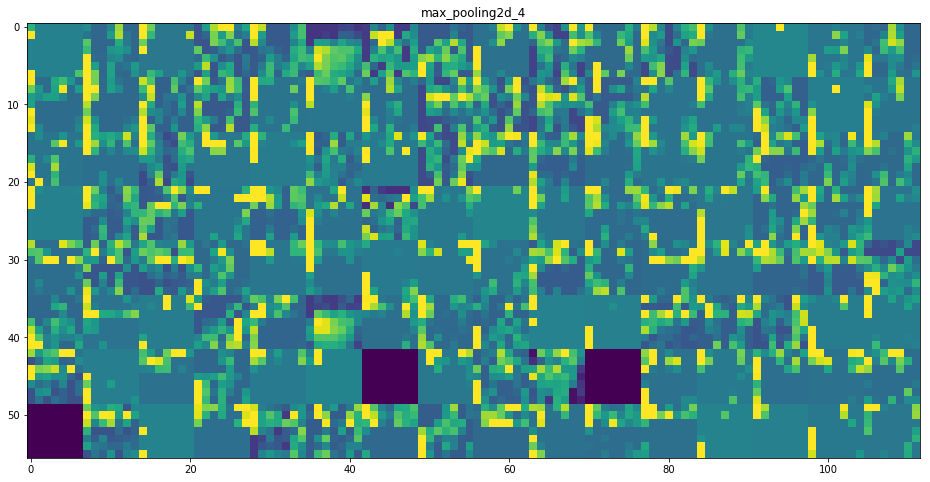

In [22]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name,layer_activation in zip(layer_names,activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols,images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col *size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='viridis')
    
    



## 2. Visualizing Convnet Filters:

### 2.1. Defining the loss tensor for filter visualization:

C:\Users\home\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


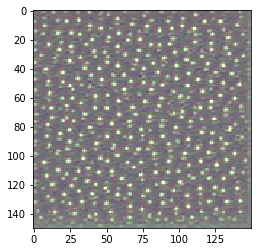

In [1]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

model_1 = VGG16(weights='imagenet',include_top = False)
layer_name = 'block3_conv1'
filter_index = 0

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x,0,1)
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

def generate_pattern(layer_name,filter_index,size = 150):
    layer_output = model_1.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model_1.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model_1.input],[loss,grads])
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128
    step = 1.
    for i in range(40):
        loss_value,grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)


plt.imshow(generate_pattern(layer_name,filter_index))

#### Result: It seems that filter 0 in layer block3_conv1 is responsive to a polka-dot pattern.

### 2.2. Generating a grid of all filter response pattern in a layer:

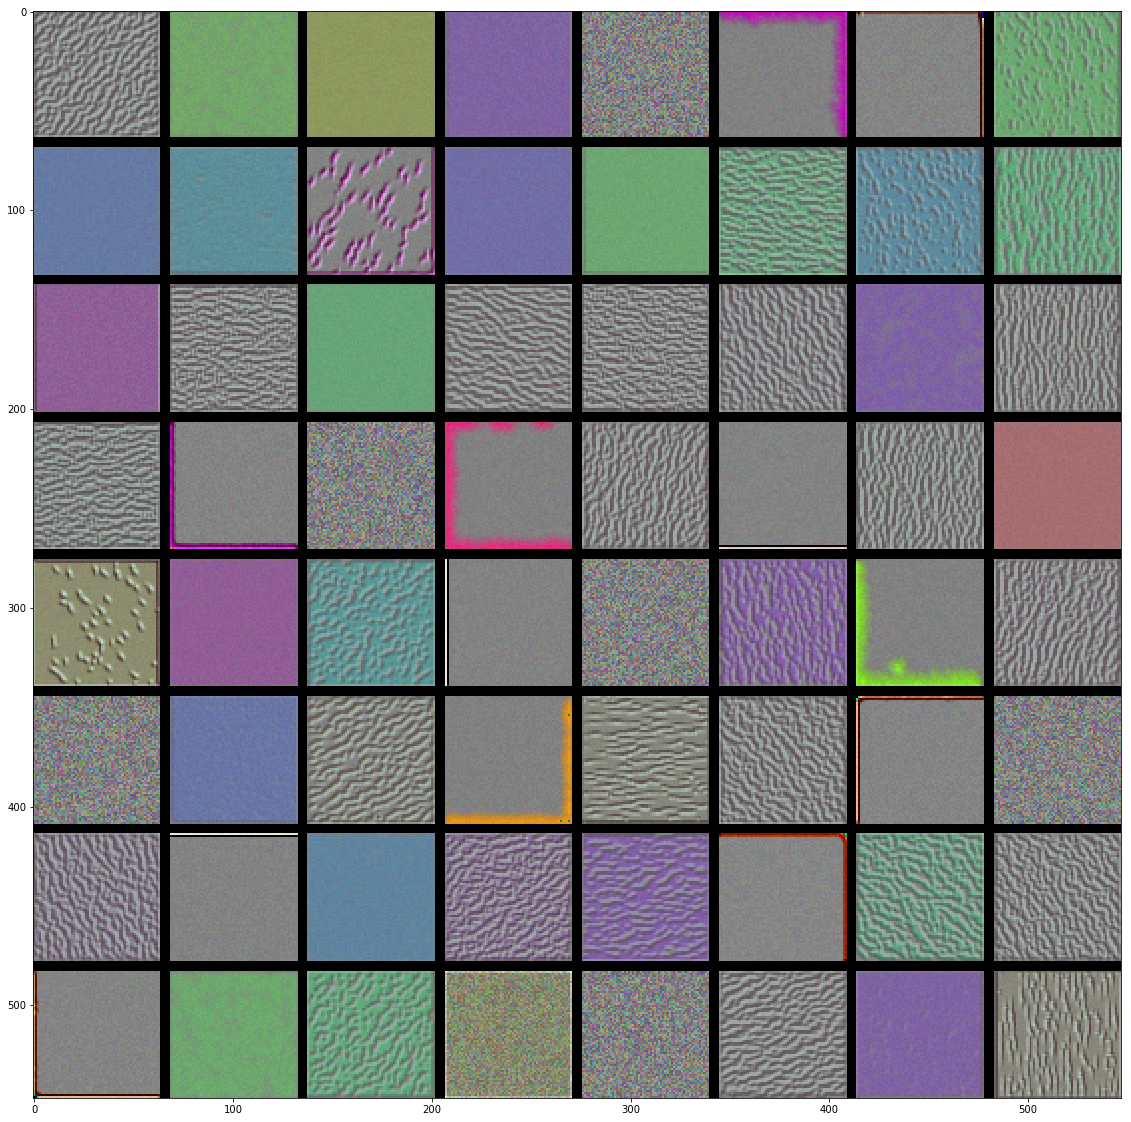

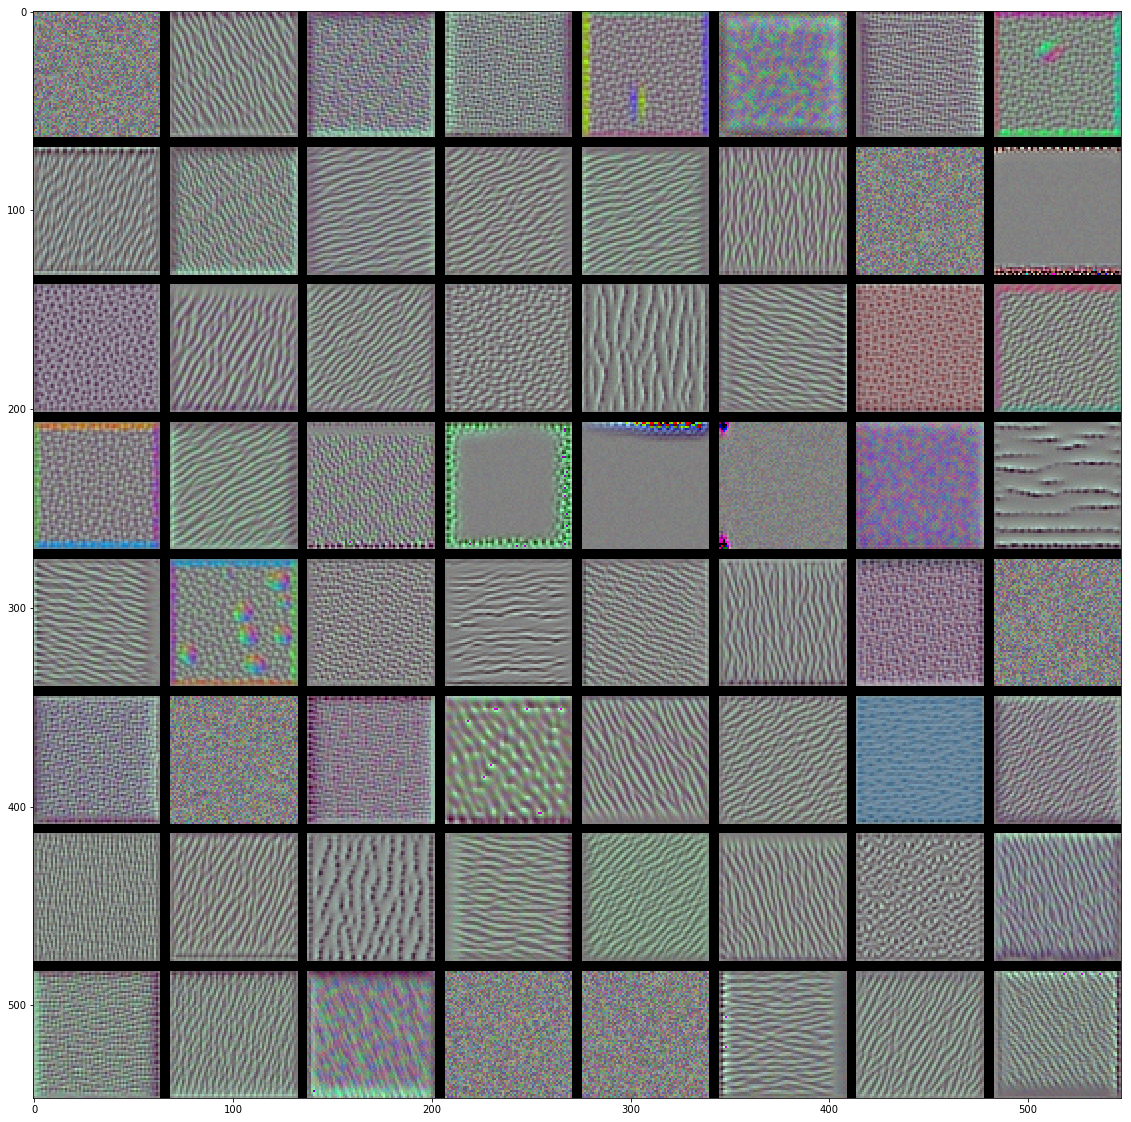

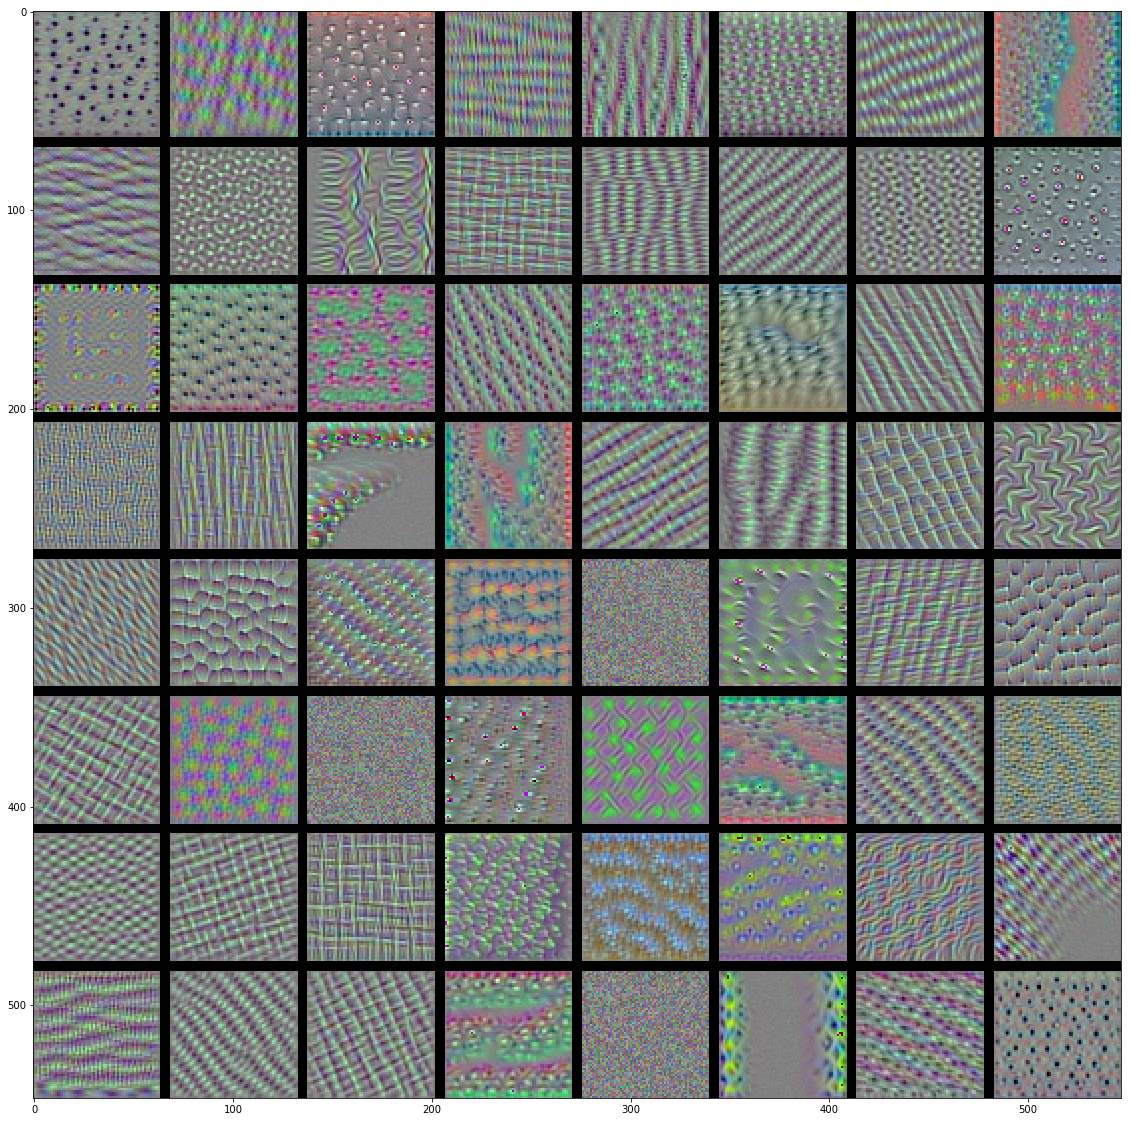

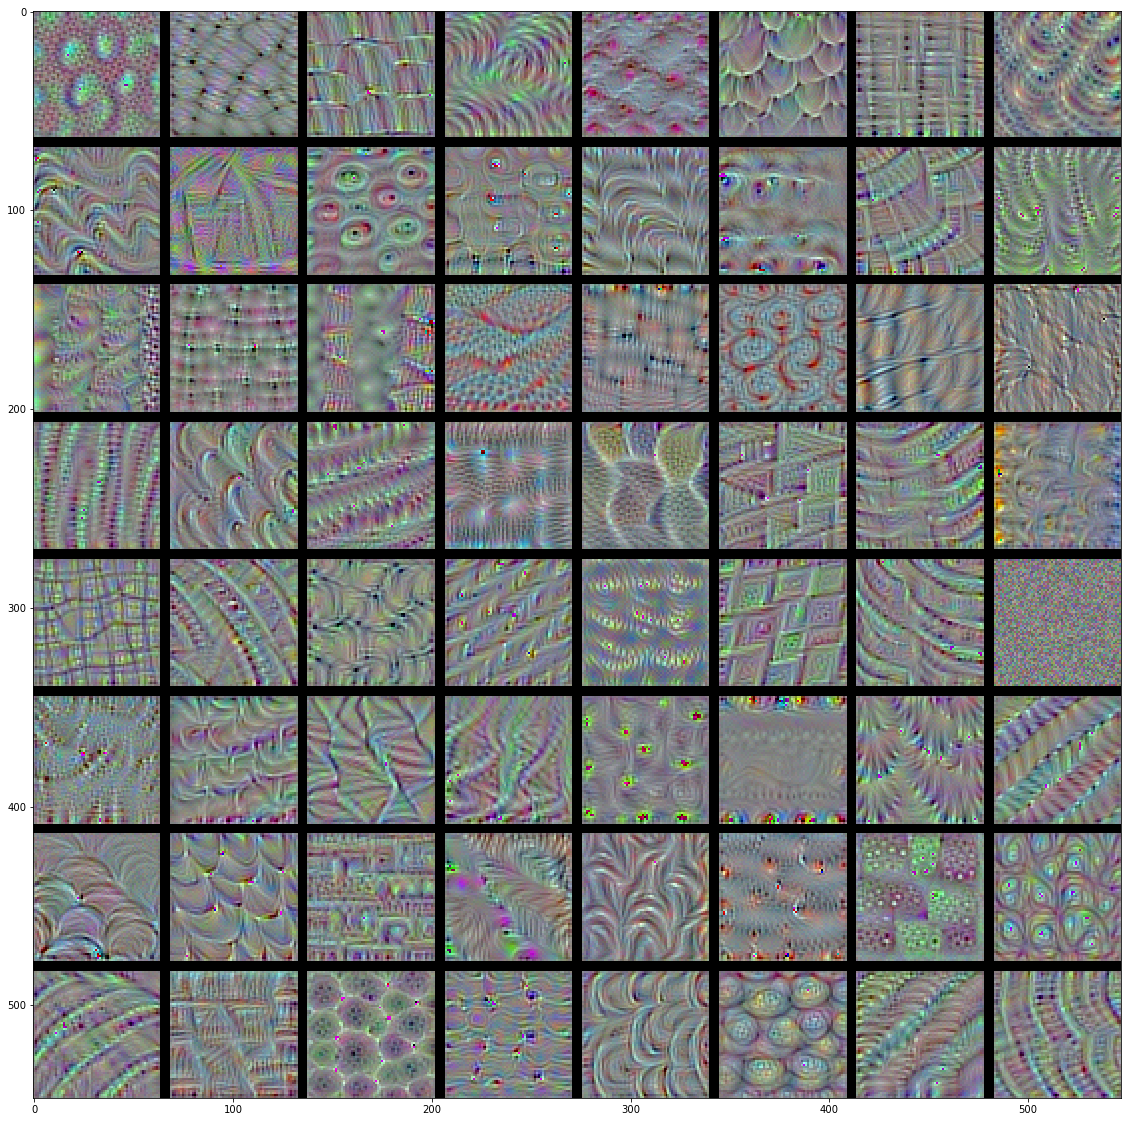

In [2]:
for layer_name in ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']:
    size = 64
    margin = 5
    results = np.zeros((8 * size + 7 * margin,8 * size + 7 * margin,3))
    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name,i + (j * 8),size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img 
    plt.figure(figsize=(20,20))
    plt.imshow(results)
